In [9]:
from os import listdir
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [10]:
def CreateMasterSpiralDF(dirName="."):
    """CreateMasterSpiralDF(dirName) where dirName is the directory name of the .spiral files,
       output pandas dataframe of all spiral files header data and filenames"""
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-7:] == '.spiral']
    
    if len(fileNames)==0:
        print "No '.spiral' files found in directory '"+dirName+"'."
        return
    
    D = {"file_name" : []}
    for index,name in enumerate(fileNames):
        f = open(name,'r')
        for i in xrange(2): colNames = f.readline().split()
        if index == 0:
            for colName in colNames:
                D[colName] = []
        D["file_name"].append(name)
        simParams = f.readline().split()
        for colIndex,colName in enumerate(colNames):
            D[colName].append(float(simParams[colIndex]))
        f.close()
    df = pd.DataFrame(D)
    return df

def CreateSpiralDF(fileName):
    """CreateSpiralDF(fileName) where fileName is the name of a '.spiral' analysis file,
       outputs pandas dataframe of time series data"""
    assert isinstance(fileName,str), "The 'fileName' argument must be a string!"
    try:
        f = open(fileName,'r')
    except:
        print "Could not open file '" + fileName + "'."
        return
    for i in xrange(4): colNames = f.readline().split()
    D = {}
    for colName in colNames:
        D[colName] = []
    for line in f:
        line = line.split()
        for colIndex, colName in enumerate(colNames):
            D[colName].append(float(line[colIndex]))
    f.close()
    df = pd.DataFrame(D)
    return df

def GetSpiralFrequencies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    freqs = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        if not (df["time"].iloc[-1] < maxTime):
            freqs[i] = GetSpiralFrequency(df,maxTime)
    masterDF["spiral_frequency"] = freqs
    
def GetBendingEnergies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    ebend = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        if not (df["time"].iloc[-1] < maxTime) and masterDF.iloc[i]["spiral_frequency"]:
            ebend[i] = df["E_bend"].iloc[-1]
        else:
            ebend[i] = None
    masterDF["E_bend"] = ebend

def GetSpiralFrequency(df,maxTime):
    assert isinstance(df,pd.DataFrame),"df needs to be pandas DataFrame type"
    N=len(df["time"])/2 #num of gridpoints
    delta=1
    time = np.array(df["time"][:N])
    z = np.array(df["tip_z_proj"][N:])
    # If we have odd time, make z and time same size
    if len(time)!=len(z):
        z = np.array(df["tip_z_proj"][N+1:])
    # Zero pad data, assuming spiral continues indefinitely
    padding=int(2**17)
    yf=np.fft.fft(z,n=padding)
    xf=np.fft.fftfreq(padding,d=delta)
    freq = xf[np.argmax(2.0/padding * np.abs(yf[0:padding/2]))]
    # If our period lasts longer than a simulation, then return freq=0 (assume no spiral) 
    if freq > 3.0/maxTime:
        return freq
    else:
        return 0
    
def PlotSpiralFrequencies(masterDF):
    maxTime = int(masterDF["nsteps"][0]/masterDF["nspec"][0])-1
    for i in masterDF.index:
        df=CreateSpiralDF(masterDF.iloc[i]["file_name"])
        # If we exited early, spiral did not form
        if not (df["time"].iloc[-1] < maxTime):
            PlotSpiralFrequency(df,maxTime)

def PlotSpiralFrequency(df,maxTime):
    assert isinstance(df,pd.DataFrame),"df needs to be pandas DataFrame type"
    assert isinstance(maxTime, (float,int)), "maxTime needs to be a float or int"
    N=len(df["time"])/2 #num of gridpoints
    delta=1
    time = np.array(df["time"][:N])
    z = np.array(df["tip_z_proj"][N:])
    # If we have odd time, make z and time same size
    if len(time)!=len(z):
        z = np.array(df["tip_z_proj"][N+1:])
    # Zero pad data, assuming spiral continues indefinitely
    padding=int(2**17)
    yf=np.fft.fft(z,n=padding)
    xf=np.fft.fftfreq(padding,d=delta)
    freq = xf[np.argmax(2.0/padding * np.abs(yf[0:padding/2]))]
    if freq < 1.0/maxTime:
        return
    guess_phase=0
    optimize_func = lambda phase: np.sin(2*np.pi*freq*(time+phase))-z
    est_phase = leastsq(optimize_func, guess_phase)[0]
    est_data = np.sin(2*np.pi*freq*(time+est_phase))
    f, ax = plt.subplots(2)
    ax[0].set_title(r"$f_{max} = $" + str(freq))
    ax[0].plot(xf,yf.real,xf,yf.imag)
    ax[0].set_xlim(0,2*freq)
    ax[0].set_xlabel("frequency")
    ax[0].set_ylabel("fft signal")
    ax[0].legend(["real","imag"],loc=1)
    ax[1].plot(time,z,'k-',time,est_data,'r--')
    ax[1].set_xlabel("sim time")
    ax[1].set_title("Filament tip orientation "+r'$U_Z$')
    ax[1].set_ylabel(r'$U_Z$')
    ax[1].set_xlim(0,min(8.0/freq,time[-1]))
    ax[1].legend(['Data','LS Fit'],loc=1)
    f.subplots_adjust(hspace=0.7)
    plt.show()
    plt.close()
    
def PlotFrequencyContour(masterDF):
    df=masterDF
    x1 = np.linspace(df['driving'].min(), df['driving'].max(), len(df['driving'].unique()))
    y1 = np.linspace(df['persistence_length'].min(), df['persistence_length'].max(), len(df['persistence_length'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    # Interpolate unstructured D-dimensional data.
    z2 = griddata((df['driving'], df['persistence_length']), df['spiral_frequency'], (x2, y2),method='linear')
    fig = plt.figure()
    ax = fig.gca()
    surf = ax.contourf(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Spiral frequency, L=50')
    plt.xlabel("Driving")
    plt.ylabel("Persistence Length")
    plt.ylim(0,8000)
    plt.show()
    plt.close()
    
def PlotEnergyContour(masterDF):
    df=masterDF
    x1 = np.linspace(df['driving'].min(), df['driving'].max(), len(df['driving'].unique()))
    y1 = np.linspace(df['persistence_length'].min(), df['persistence_length'].max(), len(df['persistence_length'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    # Interpolate unstructured D-dimensional data.
    z2 = griddata((df['driving'], df['persistence_length']), df['E_bend'], (x2, y2),method='linear')
    fig = plt.figure()
    ax = fig.gca()
    surf = ax.contourf(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Bending Energy, L=50')
    plt.xlabel("Driving")
    plt.ylabel("Persistence Length")
    plt.ylim(0,8000)
    plt.show()
    plt.close()

def GetSpiralBool(masterDF):
    spirals = pd.Series(np.zeros(len(masterDF.index)))
    for i in masterDF.index:
        if masterDF.iloc[i]["spiral_frequency"] > 0:
            spirals[i] = 1
    masterDF["spiral"] = spirals

### The next three cells are raw text and will not be evaluated until the cells are converted back to code

In [11]:
# Start here!

df_3d = pd.read_pickle('master_spiral_random.pkl')
df_fixed_dr = pd.read_pickle('master_spiral_fixed_dr.pkl')
df_fixed_lp = pd.read_pickle('master_spiral_fixed_lp.pkl') 
df_fixed_ar = pd.read_pickle('master_spiral_fixed_ar.pkl')

In [12]:
feature_names = ['length','persistence_length','driving']
df_3d_poly  = df_3d[feature_names]
length2 = df_3d_poly.length.apply(lambda x: x**2)
lplen = df_3d_poly.persistence_length / df_3d_poly.length
lendr = df_3d_poly.length * df_3d_poly.driving
df_3d_poly['length^2'] = length2
df_3d_poly['lp/len'] = lplen
df_3d_poly['len*dr'] = lendr
#df_3d_poly = pd.concat([df_3d_poly,pd.DataFrame([length2,lenlp,lendr])])
df_3d_poly.shape

(1200, 6)

In [6]:
feature_names = ['lp/len','len*dr','length']
target_name = 'spiral'
X = np.array(df_3d_poly[feature_names])
y = np.array(df_3d[target_name])
logreg = LogisticRegression(max_iter=200)
#poly = PolynomialFeatures(2,False,False)
#X=poly.fit_transform(X)
param_grid = dict(penalty=["l1",'l2'],C=[1,10,100,1000,10000,1e5,1e6,1e7,1e8])
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')
grid.fit(X,y)
print "Best logistic regression accuracy: " + str(grid.best_score_)
best = grid.best_params_
print "Best parameters: " + str(best)

Best logistic regression accuracy: 0.989166666667
Best parameters: {'penalty': 'l1', 'C': 10}


In [ ]:
feature_names = ['lp/len','len*dr','length']
target_name = 'spiral'
X = np.array(df_3d_poly[feature_names])
y = np.array(df_3d[target_name])
logreg = LogisticRegression(max_iter=200)
#poly = PolynomialFeatures(2,False,False)
#X=poly.fit_transform(X)
param_grid = dict(penalty=["l1",'l2'],C=[1,10,100,1000,10000,1e5,1e6,1e7,1e8])
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')
grid.fit(X,y)
print "Best logistic regression accuracy: " + str(grid.best_score_)
best = grid.best_params_
print "Best parameters: " + str(best)

In [7]:
logreg = LogisticRegression(penalty=best['penalty'],C=best['C'],max_iter=200)
logreg.fit(X,y)
coeff = logreg.coef_[0]
intercept = logreg.intercept_[0]
print coeff
print intercept
#coeff = [i if abs(i) > 1e-3 else 0 for i in coeff]
#print coeff

[-0.28936305  0.00932382  0.15710244]
-7.43791221269


<IPython.core.display.Javascript object>


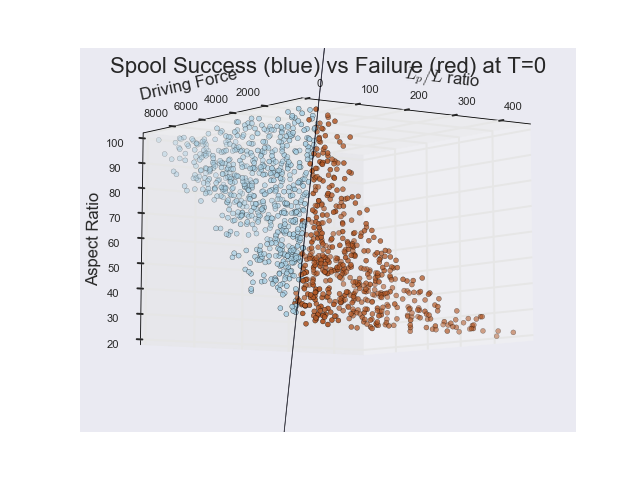

In [8]:
# Calculate the decision boundary surface
pts = 100 # num mesh points
# Set limits for our three parameters
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x3_min, x3_max = X[:, 2].min() - .5, X[:, 2].max() + .5
XX,YY = np.meshgrid(np.linspace(x1_min,x1_max,pts),np.linspace(x2_min,x2_max,pts))
ZZ = - ( intercept + coeff[0] * XX + coeff[1] * YY) / coeff[2]
#ZZ = - ( intercept + coeff[0] * XX + coeff[1] * YY + coeff[3] * XX*XX) / (coeff[2] + coeff[5]*XX)
#ZZ = (-coeff[2]-coeff[5]*XX-coeff[7]*YY + np.sqrt((coeff[2]+coeff[5]*XX+coeff[7]*YY)**2-4*coeff[8]*(intercept + coeff[0]*XX + coeff[3]*XX**2 + coeff[1]*YY + coeff[4]* XX*YY + coeff[6]*YY**2)))/(2*coeff[8])
# Plot the decision boundary
#coeff[3]=0
#coeff[4]=0
#coeff[5]=0
#ZZ = -(intercept + coeff[0] * XX + coeff[1] * YY )/(coeff[2] + coeff[3]* XX)

plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(XX,YY,ZZ,alpha=0.1)

# Plot the training points
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], X[:,2], c=-y, edgecolors='k', cmap=plt.cm.Paired)
#ax.scatter(X[0,0],X[0,1],X[0,2],c='k',edgecolors='k')
#print(y[0])
ax.set_xlabel(r'$L_p/L$ ' + "ratio")
ax.set_ylabel(r'Driving Force')
ax.set_zlabel("Aspect Ratio")
ax.set_xlim(x1_min,x1_max)
ax.set_ylim(x2_min,x2_max)
ax.set_zlim(x3_min,x3_max)
ax.set_title('Spool Success (blue) vs Failure (red) at T=0')#,y=0.1)
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.zaxis.label.set_fontsize(15)
#plt.legend(['0','1'])

In [13]:
driving = np.unique(df_fixed_dr['driving'])
assert len(driving)==1
driving = driving[0]
per_len = np.unique(df_fixed_lp['persistence_length'])
assert len(per_len)==1
per_len = per_len[0]
aspect_ratio = np.unique(df_fixed_ar['length'])
assert len(aspect_ratio)==4
#aspect_ratio = aspect_ratio[0]
print "Fixed driving: " + str(driving)
print "Fixed persistence length: " + str(per_len)
print "Fixed aspect ratios: " + str(aspect_ratio)

Fixed driving: 30.0
Fixed persistence length: 1000.0
Fixed aspect ratios: [  30.   60.   90.  120.]


In [54]:
#Adding length^2 and length*driving terms to dataframes
df_fixed_dr['len*dr'] = df_fixed_dr.length * df_fixed_dr.driving
df_fixed_lp['len*dr'] = df_fixed_lp.length * df_fixed_lp.driving
df_fixed_ar['len*dr'] = df_fixed_ar.length * df_fixed_ar.driving
df_fixed_dr['lp/len'] = df_fixed_dr.persistence_length / df_fixed_dr.length
df_fixed_lp['lp/len'] = df_fixed_lp.persistence_length / df_fixed_lp.length
df_fixed_ar['lp/len'] = df_fixed_ar.persistence_length / df_fixed_ar.length
df_ar = [df_fixed_ar[df_fixed_ar.length == aspect_ratio[i]] for i in range(4)]

<IPython.core.display.Javascript object>


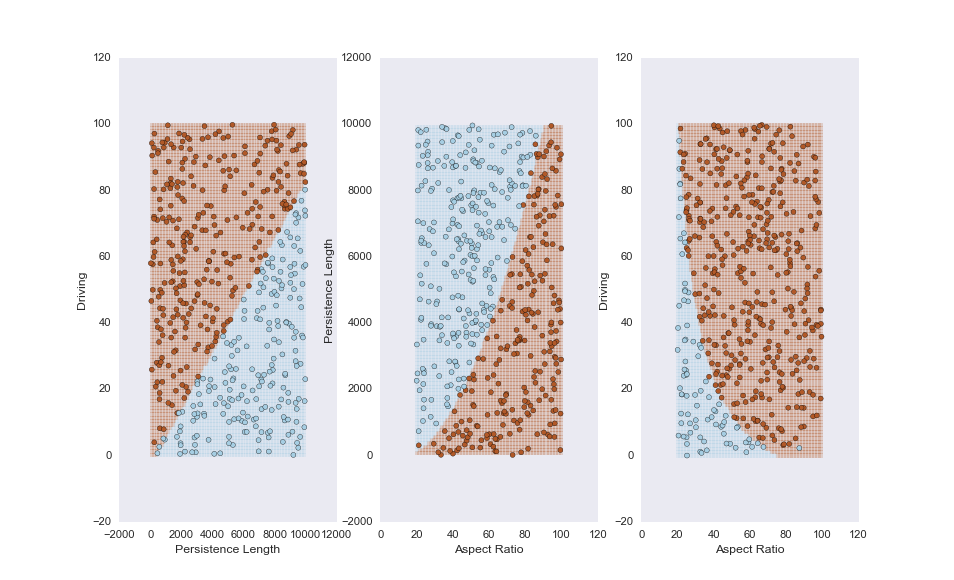

In [42]:
ar_index = 1
X_dr = np.array(df_fixed_dr[['length','persistence_length']])
y_dr = np.array(df_fixed_dr['spiral'])
X_lp = np.array(df_fixed_lp[['length','driving']])
y_lp = np.array(df_fixed_lp['spiral'])
X_ar = np.array(df_ar[ar_index][['persistence_length','driving']])
y_ar = np.array(df_ar[ar_index]['spiral'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
def bounds(X,i):
    return X[:, i].min() - .5, X[:, i].max() + .5

x1_min, x1_max = bounds(X_dr,0)
x2_min, x2_max = bounds(X_dr,1)
x3_min, x3_max = bounds(X_lp,0)
x4_min, x4_max = bounds(X_lp,1)
x5_min, x5_max = bounds(X_ar,0)
x6_min, x6_max = bounds(X_ar,1)

XX_dr,YY_dr = np.meshgrid(np.linspace(x1_min,x1_max,100),np.linspace(x2_min,x2_max,100))
ZZ_dr = logreg.predict(np.c_[YY_dr.ravel()/XX_dr.ravel(), XX_dr.ravel()*driving,XX_dr.ravel()])
#ZZ_dr = logreg.predict(np.c_[XX_dr.ravel(), YY_dr.ravel(),np.ones(XX_dr.ravel().shape)*driving,XX_dr.ravel()*XX_dr.ravel(),XX_dr.ravel()*YY_dr.ravel(),XX_dr.ravel()*driving])
#ZZ_dr = logreg.predict(np.c_[XX_dr.ravel(), YY_dr.ravel(),np.ones(XX_dr.ravel().shape)*driving,XX_dr.ravel()*driving])
ZZ_dr = ZZ_dr.reshape(XX_dr.shape)

XX_lp,YY_lp = np.meshgrid(np.linspace(x3_min,x3_max,100),np.linspace(x4_min,x4_max,100))
ZZ_lp = logreg.predict(np.c_[per_len/XX_lp.ravel(), XX_lp.ravel()*YY_lp.ravel(),XX_lp.ravel()])
#ZZ_lp = logreg.predict(np.c_[XX_lp.ravel(),np.ones(XX_lp.ravel().shape)*per_len, YY_lp.ravel(),XX_lp.ravel()*XX_lp.ravel(),XX_lp.ravel()*per_len,XX_lp.ravel()*YY_lp.ravel()])
#ZZ_lp = logreg.predict(np.c_[XX_lp.ravel(),np.ones(XX_lp.ravel().shape)*per_len, YY_lp.ravel(),XX_lp.ravel()*YY_lp.ravel()])
ZZ_lp = ZZ_lp.reshape(XX_lp.shape)

XX_ar,YY_ar = np.meshgrid(np.linspace(x5_min,x5_max,100),np.linspace(x6_min,x6_max,100))
ZZ_ar = logreg.predict(np.c_[XX_ar.ravel()/aspect_ratio[ar_index], YY_ar.ravel()*aspect_ratio[ar_index],np.ones(XX_ar.ravel().shape)*aspect_ratio[ar_index]])

#ZZ_ar = logreg.predict(np.c_[np.ones(XX_ar.ravel().shape)*aspect_ratio, XX_ar.ravel(), YY_ar.ravel(),np.ones(XX_ar.ravel().shape)*aspect_ratio*aspect_ratio,aspect_ratio*XX_ar.ravel(),aspect_ratio*YY_ar.ravel()])
#ZZ_ar = logreg.predict(np.c_[np.ones(XX_ar.ravel().shape)*aspect_ratio, XX_ar.ravel(), YY_ar.ravel(),aspect_ratio*YY_ar.ravel()])
ZZ_ar = ZZ_ar.reshape(XX_ar.shape)

fig, (ax0,ax1,ax2) = plt.subplots(1,3)

ax0.pcolormesh(XX_ar,YY_ar,ZZ_ar, cmap=plt.cm.Paired, alpha=0.2)
ax0.scatter(X_ar[:,0],X_ar[:,1], c=y_ar, edgecolors='k', cmap=plt.cm.Paired)
ax0.set_xlabel('Persistence Length')
ax0.set_ylabel('Driving')

ax1.pcolormesh(XX_dr,YY_dr,ZZ_dr, cmap=plt.cm.Paired, alpha=0.2)
ax1.scatter(X_dr[:,0],X_dr[:,1], c=y_dr, edgecolors='k', cmap=plt.cm.Paired)
ax1.set_xlabel('Aspect Ratio')
ax1.set_ylabel('Persistence Length')

ax2.pcolormesh(XX_lp,YY_lp,ZZ_lp, cmap=plt.cm.Paired, alpha=0.2)
ax2.scatter(X_lp[:,0],X_lp[:,1], c=y_lp, edgecolors='k', cmap=plt.cm.Paired)
ax2.set_xlabel('Aspect Ratio')
ax2.set_ylabel('Driving')


In [61]:
ar_index = 1
feature_names = ['lp/len','len*dr']
target_name = 'spiral'
X = np.array(df_ar[ar_index][feature_names])
y = np.array(df_ar[ar_index][target_name])
logreg = LogisticRegression(max_iter=200)
#poly = PolynomialFeatures(2,False,False)
#X=poly.fit_transform(X)
param_grid = dict(penalty=["l1",'l2'],C=[1,10,100,1000,10000,1e5,1e6,1e7,1e8])
grid = GridSearchCV(logreg, param_grid, cv=10, scoring='accuracy')
grid.fit(X,y)
print "Best logistic regression accuracy: " + str(grid.best_score_)
best = grid.best_params_
print "Best parameters: " + str(best)
logreg = LogisticRegression(penalty=best['penalty'],C=best['C'],max_iter=200)
logreg.fit(X,y)
coeff = logreg.coef_[0]
intercept = logreg.intercept_[0]
print "Coeffs: " + str(coeff)
print "Intercept: " + str(intercept)
print "Aspect Ratio: " + str(aspect_ratio[ar_index])
print str(coeff[0]) + " Lp/L + " + str(coeff[1]) + " F_dr + " + str(intercept) + " = 0"

Best logistic regression accuracy: 0.998
Best parameters: {'penalty': 'l1', 'C': 10}
Coeffs: [-0.5167735   0.01754219]
Intercept: 1.55259740926
Aspect Ratio: 60.0
-0.51677350019 Lp/L + 0.0175421903464 F_dr + 1.55259740926 = 0


<IPython.core.display.Javascript object>


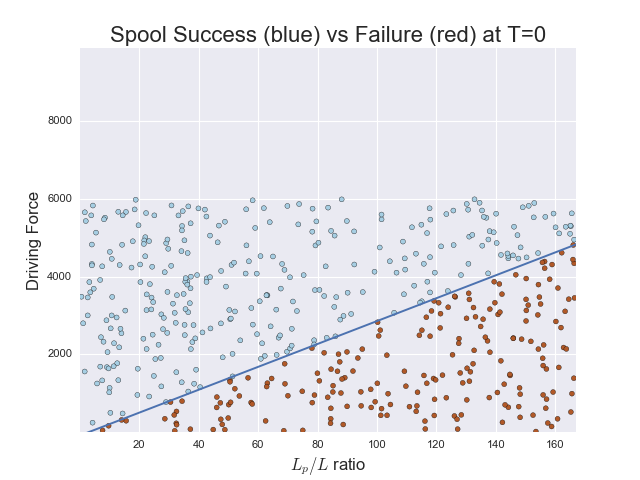

In [62]:
# Calculate the decision boundary surface
pts = 100 # num mesh points
# Set limits for our three parameters
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
XX = np.linspace(x1_min,x1_max,pts)
YY = - ( intercept + coeff[0] * XX) / coeff[1]

plt.figure()
plt.plot(XX,YY)

# Plot the training points
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=-y, edgecolors='k', cmap=plt.cm.Paired)
#ax.scatter(X[0,0],X[0,1],X[0,2],c='k',edgecolors='k')
#print(y[0])
ax.set_xlabel(r'$L_p/L$ ' + "ratio")
ax.set_ylabel(r'Driving Force')
#ax.set_zlabel("Aspect Ratio")
ax.set_xlim(x1_min,x1_max)
ax.set_ylim(x2_min,x2_max)
#ax.set_zlim(x3_min,x3_max)
ax.set_title('Spool Success (blue) vs Failure (red) at T=0')#,y=0.1)
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
#ax.zaxis.label.set_fontsize(15)
#plt.legend(['0','1'])

In [77]:
60*0.16

9.6

In [78]:
9.6*25

240.0

In [79]:
240/6

40

In [86]:
10 * 0.16 * 25 / 6

6.666666666666667

In [92]:
kinesin_force = 6 # pN, force generated by single kinesin
binding_site_density = 0.4 # sites/nm, maximum binding density of MT (for all 13 protofilaments)
bound_protofilament_fraction = 3.0/13 # estimate of how many protofilaments out of 13 can be bound by gliding MT
sigma = 25 # nm, simulation unit length
driving_unit = 0.16 # pN/nm, simulation unit force per unit length
kinesin_force*binding_site_density*bound_protofilament_fraction*sigma*driving_unit

2.215384615384616

In [88]:
4.6/0.16

28.749999999999996

In [93]:
6 *0.4/13.0*3

0.553846153846154

In [94]:
0.4/13.0*3*25

2.307692307692308

In [95]:
2.3 * 6

13.799999999999999

In [96]:
13.8/25

0.552

In [100]:
3.5*0.16*100*25

1400.0000000000002

In [98]:
0.55/0.16

3.4375

In [101]:
200**3

8000000

In [41]:
100/np.log(100)

21.714724095162591

<IPython.core.display.Javascript object>


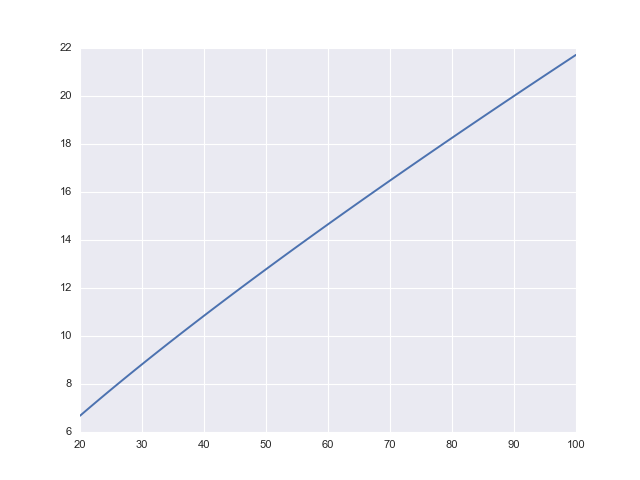

In [48]:
y = lambda x: x/np.log(x)
x = np.linspace(20,100,100)
plt.figure()
plt.plot(x,y(x))
plt.show()